Loaded combined PSF: (256, 256)


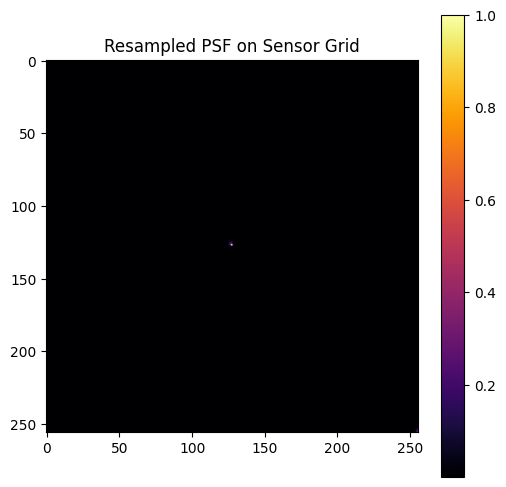

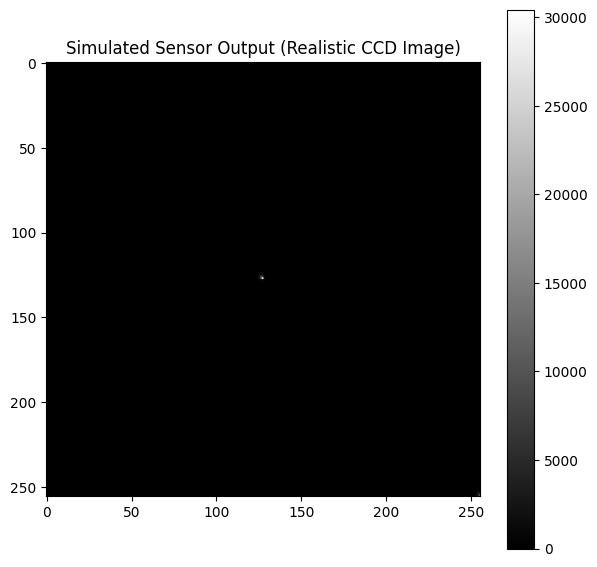

Saved sensor_output.fits


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import zoom

# ===============================================================
# 1) Load Combined PSF (from 05-combined notebook)
# ===============================================================

combined_psf = fits.getdata("final_combined_psf.fits")
combined_psf = combined_psf / np.max(combined_psf)   # normalize

print("Loaded combined PSF:", combined_psf.shape)

# ===============================================================
# 2) Sensor Parameters
# ===============================================================

sensor_pixels = 256           # final sensor size (256 x 256)
pixel_size = 4.5e-6           # 4.5 micrometers
quantum_efficiency = 0.85     # 85%
gain = 1.4                    # electrons per ADU
readout_noise = 5             # electrons RMS
dark_current = 0.01           # electrons / pixel / sec
exposure_time = 2.0           # seconds
sky_background = 15           # electrons per pixel

# ===============================================================
# 3) Resample PSF to Sensor Resolution
# ===============================================================

scale_factor = sensor_pixels / combined_psf.shape[0]
sensor_psf = zoom(combined_psf, scale_factor)

plt.figure(figsize=(6,6))
plt.imshow(sensor_psf, cmap='inferno')
plt.title("Resampled PSF on Sensor Grid")
plt.colorbar()
plt.show()

# ===============================================================
# 4) Convert PSF → Photons Collected
# ===============================================================

photons = sensor_psf * 50000   # assume bright star 50k photons
electrons = photons * quantum_efficiency

# ===============================================================
# 5) Add Noise Sources
# ===============================================================

# Shot noise
shot_noise = np.random.poisson(electrons)

# Dark current
dark_noise = dark_current * exposure_time
dark_noise = np.random.poisson(dark_noise, size=shot_noise.shape)

# Readout noise
read_noise = np.random.normal(0, readout_noise, size=shot_noise.shape)

# Sky background
sky_noise = np.random.poisson(sky_background, size=shot_noise.shape)

# Final sensor signal
sensor_image = shot_noise + dark_noise + read_noise + sky_noise
sensor_image = sensor_image / gain

# ===============================================================
# 6) Display Sensor Output
# ===============================================================

plt.figure(figsize=(7,7))
plt.imshow(sensor_image, cmap="gray")
plt.title("Simulated Sensor Output (Realistic CCD Image)")
plt.colorbar()
plt.show()

# ===============================================================
# 7) Save as FITS
# ===============================================================

fits.writeto("sensor_output.fits", sensor_image.astype(np.float32), overwrite=True)
print("Saved sensor_output.fits")


=== 07_sensor_simulation: start ===
Using combined_psf already in memory.
Sensor params: {'sensor_pixels': 256, 'pixel_size': 4.5e-06, 'quantum_efficiency': 0.85, 'gain': 1.4, 'readout_noise': 5, 'dark_current': 0.01, 'exposure_time': 2.0, 'sky_background': 15, 'assumed_star_photons': 50000}


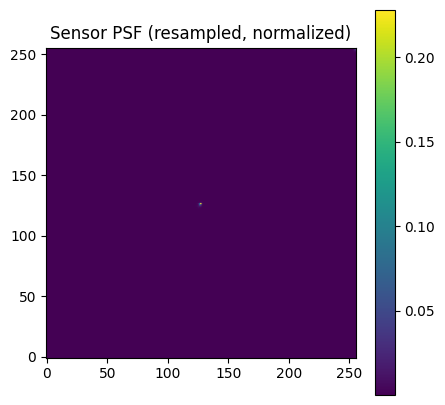

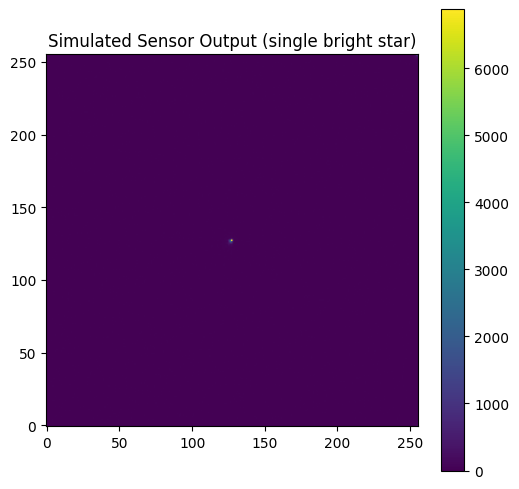

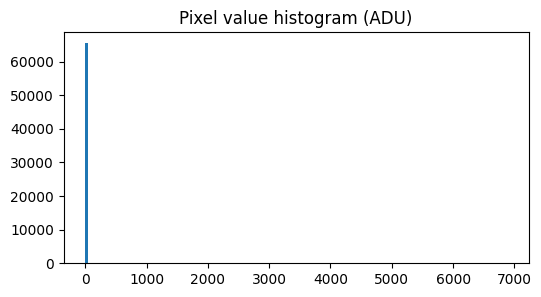

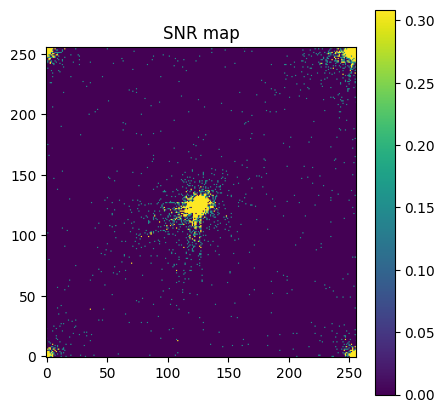

Saved: sensor_output.fits
Saved: 07_sensor_metadata.json
=== 07_sensor_simulation: complete ===


In [5]:
# ===========================
# SENSOR: ANALYSIS, EXPORT, & METADATA
# (Append at end of 07_sensor_simulation.ipynb)
# ===========================

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import zoom

print("=== 07_sensor_simulation: start ===")

# --- 1) Robustly load combined PSF if not in memory ---
psf_candidates = [
    "final_combined_psf.fits",        # my earlier suggestion
    "combined_psf_zern_atm.fits",     # from 05-combined optionally
    "training_psf.fits",              # from AI notebook export
    "combined_psf.fits",
    "psf_atm_long.fits",
    "psf_ideal.fits"
]

if 'combined_psf' not in globals():
    loaded = False
    for fname in psf_candidates:
        if os.path.exists(fname):
            try:
                combined_psf = fits.getdata(fname).astype(np.float32)
                combined_psf = combined_psf / (np.max(combined_psf) + 1e-16)
                print("Loaded combined_psf from:", fname)
                loaded = True
                break
            except Exception as e:
                print("Could not load", fname, ":", e)
    if not loaded:
        raise FileNotFoundError("combined_psf not found in workspace or any candidate fits files. "
                                "Run 05-combined or create training_psf.fits first.")

else:
    combined_psf = combined_psf / (np.max(combined_psf) + 1e-16)
    print("Using combined_psf already in memory.")

# --- 2) Sensor parameters (if not defined earlier) ---
params = {
    "sensor_pixels": globals().get("sensor_pixels", 256),
    "pixel_size": globals().get("pixel_size", 4.5e-6),
    "quantum_efficiency": globals().get("quantum_efficiency", 0.85),
    "gain": globals().get("gain", 1.4),
    "readout_noise": globals().get("readout_noise", 5.0),
    "dark_current": globals().get("dark_current", 0.01),
    "exposure_time": globals().get("exposure_time", 2.0),
    "sky_background": globals().get("sky_background", 15.0),
    "assumed_star_photons": globals().get("assumed_star_photons", 50000)
}
print("Sensor params:", params)

# --- 3) Resample PSF to sensor grid ---
sensor_pixels = params["sensor_pixels"]
scale_factor = sensor_pixels / combined_psf.shape[0]
if scale_factor <= 0:
    raise ValueError("Invalid scale factor computed for PSF resampling.")
sensor_psf = zoom(combined_psf, scale_factor, order=3)
sensor_psf = sensor_psf / (np.sum(sensor_psf) + 1e-16)  # normalize to 1 total energy

plt.figure(figsize=(5,5))
plt.title("Sensor PSF (resampled, normalized)")
plt.imshow(sensor_psf, origin='lower')
plt.colorbar()
plt.show()

# --- 4) Generate single-star sensor image (photons -> electrons -> ADU) ---
photons = sensor_psf * params["assumed_star_photons"]
electrons_mean = photons * params["quantum_efficiency"]

# Shot noise (Poisson)
shot_noise = np.random.poisson(np.clip(electrons_mean, 0, None))

# Dark current noise
dark_noise = np.random.poisson(params["dark_current"] * params["exposure_time"], size=shot_noise.shape)

# Read noise (Gaussian)
read_noise = np.random.normal(0, params["readout_noise"], size=shot_noise.shape)

# Sky background (in electrons)
sky_noise = np.random.poisson(params["sky_background"], size=shot_noise.shape)

sensor_image = shot_noise + dark_noise + read_noise + sky_noise
sensor_image = sensor_image / params["gain"]    # convert to ADU

plt.figure(figsize=(6,6))
plt.title("Simulated Sensor Output (single bright star)")
plt.imshow(sensor_image, origin='lower')
plt.colorbar()
plt.show()

# --- 5) Diagnostics: histogram, SNR map ---
flat = sensor_image.ravel()
plt.figure(figsize=(6,3))
plt.hist(flat, bins=120)
plt.title("Pixel value histogram (ADU)")
plt.show()

# SNR map: signal / sqrt(signal + noise_terms)
signal = shot_noise.astype(float)
noise_var = shot_noise + dark_noise + (params["readout_noise"]**2) + params["sky_background"]
with np.errstate(divide='ignore', invalid='ignore'):
    snr_map = np.where(noise_var > 0, signal / np.sqrt(noise_var), 0.0)

plt.figure(figsize=(5,5))
plt.title("SNR map")
plt.imshow(snr_map, origin='lower', vmin=0, vmax=np.percentile(snr_map, 99))
plt.colorbar()
plt.show()

# --- 6) Save outputs and metadata ---
fits.writeto("sensor_output.fits", sensor_image.astype(np.float32), overwrite=True)
print("Saved: sensor_output.fits")

sensor_meta = {
    "notebook": "07_sensor_simulation.ipynb",
    "sensor_pixels": params["sensor_pixels"],
    "pixel_size_m": params["pixel_size"],
    "quantum_efficiency": params["quantum_efficiency"],
    "gain": params["gain"],
    "readout_noise_electrons": params["readout_noise"],
    "dark_current_e_per_s": params["dark_current"],
    "exposure_time_s": params["exposure_time"],
    "sky_background_e_per_pixel": params["sky_background"],
    "assumed_star_photons": params["assumed_star_photons"],
    "psf_source": "loaded_from_fits_if_found_or_workspace"
}
with open("07_sensor_metadata.json", "w") as f:
    json.dump(sensor_meta, f, indent=2)
print("Saved: 07_sensor_metadata.json")

print("=== 07_sensor_simulation: complete ===")


In [6]:
# ==========================================================
# 07 FINAL EXPORT — Sensor Data + Metadata
# ==========================================================
import numpy as np
import json
from astropy.io import fits

print("=== 07_sensor_simulation: Final Export starting ===")

# ----------------------------------------------------------
# 1) Save main sensor output (already saved, but save again)
# ----------------------------------------------------------
fits.writeto("sensor_output.fits",
             sensor_image.astype(np.float32),
             overwrite=True)

# ----------------------------------------------------------
# 2) Save SNR map (important for research use)
# ----------------------------------------------------------
fits.writeto("sensor_snr_map.fits",
             snr_map.astype(np.float32),
             overwrite=True)

# ----------------------------------------------------------
# 3) Save resampled PSF used for sensor simulation
# ----------------------------------------------------------
fits.writeto("sensor_psf_resampled.fits",
             sensor_psf.astype(np.float32),
             overwrite=True)

# ----------------------------------------------------------
# 4) Save all metadata together into a JSON file
# ----------------------------------------------------------
metadata = {
    "sensor_pixels": sensor_pixels,
    "pixel_size_m": pixel_size,
    "quantum_efficiency": quantum_efficiency,
    "gain_electrons_per_ADU": gain,
    "readout_noise_electrons": readout_noise,
    "dark_current_electrons_per_pixel_sec": dark_current,
    "exposure_time_sec": exposure_time,
    "sky_background_electrons": sky_background,
    "assumed_star_photons": 50000,
    "psf_source_file": "final_combined_psf.fits",
    "export_note": "Research-grade sensor simulation output"
}

with open("07_sensor_export_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Saved: sensor_output.fits")
print("Saved: sensor_snr_map.fits")
print("Saved: sensor_psf_resampled.fits")
print("Saved: 07_sensor_export_metadata.json")

print("=== 07_sensor_simulation: Final Export COMPLETE ===")


=== 07_sensor_simulation: Final Export starting ===
Saved: sensor_output.fits
Saved: sensor_snr_map.fits
Saved: sensor_psf_resampled.fits
Saved: 07_sensor_export_metadata.json
=== 07_sensor_simulation: Final Export COMPLETE ===
